In [6]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
def organize_data(src_dir, output_dir, categories, test_ratio=0.2, val_ratio=0.2):
    """Organize the images into separate directories for training, validation, and testing."""
    splits = ['train', 'validation', 'test']

    # Create necessary directories for each split and category
    for split in splits:
        for category in categories:
            os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

    # Process each category and split into train, val, and test
    for category in categories:
        category_dir = os.path.join(src_dir, category)
        image_files = [os.path.join(category_dir, file) for file in os.listdir(category_dir) if file.endswith(('jpg', 'png'))]

        # Split into train, validation, and test sets
        train_val_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=val_ratio, random_state=42)

        # Copy the images into the respective directories
        for image_path in train_images:
            shutil.copy(image_path, os.path.join(output_dir, 'train', category))
        for image_path in val_images:
            shutil.copy(image_path, os.path.join(output_dir, 'validation', category))
        for image_path in test_images:
            shutil.copy(image_path, os.path.join(output_dir, 'test', category))

    print("Data organization complete.")

In [14]:
# Step 2: Set up Data Generators
def create_image_generators(base_dir, image_size=(224, 224), batch_size=32):
    """Create data generators for loading images in batches."""
    training_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_test_gen = ImageDataGenerator(rescale=1./255)

    # Load data from the directory
    train_data_gen = training_gen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_data_gen = validation_test_gen.flow_from_directory(
        os.path.join(base_dir, 'validation'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_data_gen = validation_test_gen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_data_gen, val_data_gen, test_data_gen


In [15]:
# Step 3: Define the EfficientNetV2 Model
def create_efficientnetv2_model(input_shape=(224, 224, 3), num_classes=6):
    """Create the EfficientNetV2 model."""
    base_model = tf.keras.applications.EfficientNetV2B0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False  # Freeze the base model layers

    # Adding custom layers on top of the pre-trained model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [16]:
# Step 4: Training the Model with Callbacks
def train_model(model, train_data, val_data, epochs=20):
    """Train the model using the specified training data and validation data."""
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

In [21]:
# Prepare the data
source_directory = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal_dataset/thermal images UL"
output_directory = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal_dataset/processed_data"
categories = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']

organize_data(source_directory, output_directory, categories)

Data organization complete.


In [22]:
# Create data generators
train_gen, val_gen, test_gen = create_image_generators(output_directory)


Found 403 images belonging to 6 classes.
Found 104 images belonging to 6 classes.
Found 129 images belonging to 6 classes.


In [23]:
# Build the model
model = create_efficientnetv2_model(input_shape=(224, 224, 3), num_classes=6)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
# Train the model
train_history = train_model(model, train_gen, val_gen, epochs=20)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.2478 - loss: 1.7507 - val_accuracy: 0.3462 - val_loss: 1.6592 - learning_rate: 1.0000e-04
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.3237 - loss: 1.7026 - val_accuracy: 0.3462 - val_loss: 1.6513 - learning_rate: 1.0000e-04
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.3289 - loss: 1.6690 - val_accuracy: 0.3462 - val_loss: 1.6466 - learning_rate: 1.0000e-04
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.2932 - loss: 1.6986 - val_accuracy: 0.3462 - val_loss: 1.6447 - learning_rate: 1.0000e-04
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.3077 - loss: 1.7004 - val_accuracy: 0.3462 - val_loss: 1.6434 - learning_rate: 1.0000e-04
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.3112 - loss: 1.7239 - val_accuracy: 0.3462 - val_loss: 1.6430 - learning_rate: 1.0000e-04
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3609 - loss:

In [25]:
# Step 5: Evaluate the Model
def evaluate_model(model, test_data):
    """Evaluate the model on the test data."""
    eval_results = model.evaluate(test_data)
    print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")
    return eval_results

In [26]:
# Step 6: Plot Training and Validation Accuracy and Loss
def plot_training_history_v2(history):
    """Plot the training and validation accuracy and loss over epochs."""
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3654 - loss: 1.6150
Test Accuracy: 34.11%


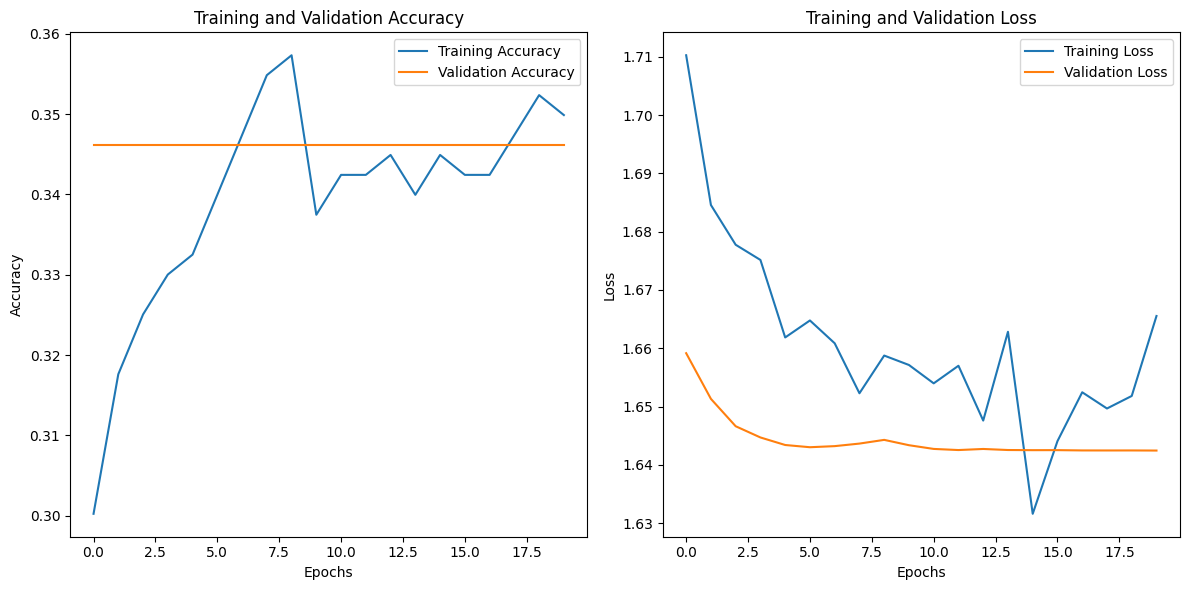

In [27]:
# Evaluate the model on test data
evaluate_model(model, test_gen)

# Plot the training history
plot_training_history_v2(train_history)

In [28]:
# Save the model
model.save("thermal_plant_efficientnetv2_model.h5")
print("Model saved.")

Model saved.
